In [7]:
import pickle
import marshal
import numpy as np
import matplotlib.pyplot as plt
from save_measures import Run
from config import ExperimentType, params
from correlations import initialization_correlation, conditional_correlation, hp_correlation
from plotting import correlation_envelope

In [31]:
def differ_in_only_key(config_pair, hp):
    i = params.index(hp)
    
    fixed1 = tuple(config_pair[0][0][j] for j in range(len(params)) if j != i)
    fixed2 = tuple(config_pair[1][0][j] for j in range(len(params)) if j != i)
    
    truth = fixed1 == fixed2 and config_pair[0][0][i] != config_pair[1][0][i] \
        and config_pair[0][1] != 3 and config_pair[1][1] != 3 
    
    if truth:
        return fixed1
    else:
        return None

In [4]:
with open("./data.nosync/pre-comp-correlations-future/margin-best.pickle", "rb") as f:
    pair_corrs = pickle.load(f)

In [19]:
corr_dict = pair_corrs["weighted"]
hp = "lr"

In [20]:
len(corr_dict)

16290

In [80]:
envs = {}

for hp_pair, steps_dict in corr_dict.items():
    key = differ_in_only_key(hp_pair, hp)
    
    if key is None:
        continue
    
    key_corrs = envs.get(key, {})
    
    for step in [0.001, 0.01, 0.1, 1, 5, 10, 15, 20]:
        if step not in steps_dict:
            continue
        
        measures_dict, _, total_weight = steps_dict[step]
        
        step_corrs = key_corrs.get(step, {})
        
        if total_weight > 1:
            for measure, corr in measures_dict.items():
                measure_corrs = step_corrs.get(measure, [])
                measure_corrs.append(corr)
                step_corrs[measure] = measure_corrs
                
        key_corrs[step] = step_corrs
        
    envs[key] = key_corrs

env_corrs = {}

for key, key_corrs in envs.items():
    env_corrs[key] = {}
    
    for step, step_corrs in key_corrs.items():
        env_corrs[key][step] = {}
        
        for measure, measure_corrs in step_corrs.items():
            env_corrs[key][step][measure] = np.mean(measure_corrs)

In [81]:
e = {k: v for k, v in env_corrs.items() if k[3] == 0}

In [82]:
collect_dists = {}

for key, key_corrs in e.items():
    for step, step_corrs in key_corrs.items():
        collect_dists[step] = collect_dists.get(step, {})
        
        for measure, corr in step_corrs.items():
            collect_dists[step][measure] = collect_dists[step].get(measure, [])
            collect_dists[step][measure].append(corr)

In [103]:
def box_plot_batches(ax, steps, corrs_list):
    bp = ax.boxplot(corrs_list, positions=steps, widths=5)
    ax.plot(steps, [np.median(c) for c in corrs_list])
    ax.set_ylim([-1, 1])
    ax.set_xlim([-5, 105])
    ax.set_xlabel("batches")
    ax.set_ylabel("correlation")
    
def box_plot_epochs(ax, steps, corrs_list):
    ax.boxplot(corrs_list, positions=steps, widths=1)
    ax.plot(steps, [np.median(c) for c in corrs_list])
    ax.set_ylim([-1, 1])
    ax.set_xlim(0, 21)
    ax.set_xlabel("epochs")

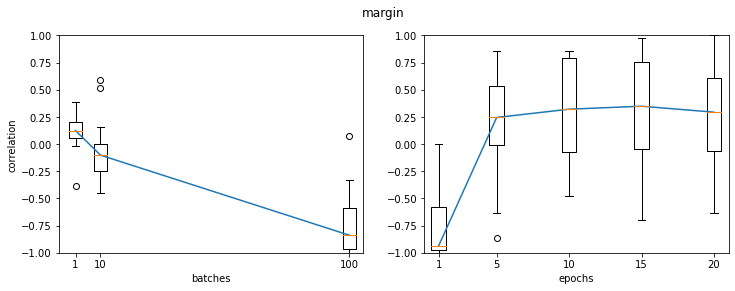

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("margin")

batches = [0.001, 0.01, 0.1]
box_plot_batches(ax1, [int(i * 1000) for i in batches], [collect_dists[i]["margin"] for i in batches])

epochs = [1, 5, 10, 15, 20]
box_plot_epochs(ax2, epochs, [collect_dists[i]["margin"] for i in epochs])